In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import geopandas as gpd
import os, lzma, csv, collections, json
import numpy as np

import open_cp.network
import open_cp.geometry
import open_cp.sources.chicago
import matplotlib.patches
import shapely.geometry

import tilemapbase
import pyproj
proj = pyproj.Proj({"init":"epsg:3528"})
import descartes

In [2]:
def project_to_tilemapbase(points):
    points = np.asarray(points)
    assert points.shape[-1] == 2
    xc, yc = proj(points[:,0], points[:,1], inverse=True)
    xcs, ycs = [], []
    for (x,y) in zip(xc, yc):
        x, y = tilemapbase.project(x, y)
        xcs.append(x)
        ycs.append(y)
    return np.asarray([xcs, ycs]).T

In [3]:
data_dir = os.path.join("/media", "OTHERDATA", "Data")
#data_dir = os.path.join("..", "..", "..", "..", "Data")
#os.listdir(data_dir)
filename = os.path.join(data_dir, "chicago_all.csv.xz")

In [4]:
# Don't want all locations, just unique ones!

with lzma.open(filename, "rt", encoding="utf8") as f:
    reader = csv.reader(f)
    header = next(reader)
    out = collections.defaultdict(list)
    #data = []
    for row in reader:
        if row[15] == "":
            continue
        year = int(row[17])
        if year <= 2001:
            continue
        block, x, y = row[3], float(row[15]), float(row[16])
        if x < 10 or y < 10:
            continue
        out[block].append((x,y))
        #data.append((block, x, y, row[5], row[6], row[7]))
out = {k : np.asarray(list(set(out[k]))) / open_cp.sources.chicago._FEET_IN_METERS for k in out}
len(out)

51660

In [5]:
with open("chicago.graph", "rb") as f:
    graph = open_cp.network.PlanarGraph.from_bytes(f.read())

with lzma.open("chicago_graph_names.xz", "rt") as f:
    edge_name_lookup = json.load(f)
edge_name_lookup = {int(k):v for k,v in edge_name_lookup.items()}
assert list(range(graph.number_edges)) == list(edge_name_lookup)

with lzma.open("chicago_graph_addresses.xz", "rt") as f:
    canonical_names_lookup = json.load(f)
canonical_names_lookup = {int(k):v for k,v in canonical_names_lookup.items()}
assert list(range(graph.number_edges)) == list(canonical_names_lookup)

## Assign points to nearest edge

In [6]:
projected = collections.defaultdict(list)
for key in out:
    for x, y in out[key]:
        (v1, v2), t = graph.project_point_to_graph(x, y)
        xx = graph.vertices[v1][0] * (1-t) + graph.vertices[v2][0] * t
        yy = graph.vertices[v1][1] * (1-t) + graph.vertices[v2][1] * t
        projected[key].append((xx, yy))

In [7]:
sum(len(li) for _, li in projected.items())

684742

In [8]:
projected = {k:list(set(v)) for k,v in projected.items()}
sum(len(li) for _, li in projected.items())

683912

## Save and visualise

- Save out the list of projected points
- Save out the graph

In [8]:
import shapely.geometry

names, geo = [], []
for key in projected:
    for x, y in projected[key]:
        names.append(key)
        geo.append( shapely.geometry.Point(x, y) )

frame = gpd.GeoDataFrame({"name" : names})
frame.geometry = geo
frame.crs = {"init":"epsg:3528"}
frame.head()

,name,geometry
0,022XX N CANNON DR,POINT (358139.6093862912 583799.5027595144)
1,022XX N CANNON DR,POINT (358154.2104958437 583742.4759889914)
2,022XX N CANNON DR,POINT (358149.6210040117 583760.8358081643)
3,022XX N CANNON DR,POINT (358153.2065454096 583746.4921958186)
4,022XX N CANNON DR,POINT (358157.7781112344 583728.2040879074)


In [9]:
frame.to_file("chicago_post_2001_to_graph")

## Find curious encodings...

As ever, a vast amount of noise...

In [35]:
# Check re-projecting does essentially nothing
for key in projected:
    for x, y in projected[key]:
        (v1, v2), t = graph.project_point_to_graph(x, y)
        xx = graph.vertices[v1][0] * (1-t) + graph.vertices[v2][0] * t
        yy = graph.vertices[v1][1] * (1-t) + graph.vertices[v2][1] * t
        d = np.sqrt((x-xx)**2 + (y-yy)**2)
        assert d < 1e-9

In [36]:
edge_to_block = collections.defaultdict(set)

for key in projected:
    for x, y in projected[key]:
        (v1, v2), _ = graph.project_point_to_graph(x, y)
        e, _ = graph.find_edge(v1, v2)
        edge_to_block[e].add(key)
        
edge_to_block = {k:v for k,v in edge_to_block.items()}

In [37]:
postfix = {" AV":"AVE", " BL":"BLVD", " BV":"BLVD", " STREET":"ST", "TR":"TER", "PW":"PKWY",
          "PK":"PARK"}
digit_remove = {"ST", "ND", "RD", "TH"}
replace = {" MARTN LUTHR ":" MARTIN LUTHER ", " MC LEAN ":" MCLEAN ",
            " LA CROSSE ":" LACROSSE ", " MONT CLARE ":" MONTCLARE ",
            " MC DOWELL ":" MCDOWELL ", " MC VICKER ":" MCVICKER "}

def normalise(key):
    key = key.upper()
    if key[-1] == ".":
        key = key[:-1]
    for f,t in postfix.items():
        if key.endswith(f):
            key = key[:-len(f)] + " " + t
    for f,t in replace.items():
        key = key.replace(f, t)
    for r in digit_remove:
        i = -1
        while True:
            i = key.find(r, i+1)
            if i == -1:
                break
            if key[i-1] in "0123456789":
                key = key[:i] + key[i+2:]
        
    for _ in range(10):
        key = key.replace("  ", " ")
    return key

assert normalise("ags  352 av") == "AGS 352 AVE"
assert normalise("BOB 51ST ST") == "BOB 51 ST"
assert normalise("01XX SHA ST.") == "01XX SHA ST"

def ignore_number(key):
    i = key.find(" ")
    return key[i+1:]

assert ignore_number('051XX S DAMEN AVE') == 'S DAMEN AVE'

def ignore_postfix(key):
    p = key.split(" ")[-1]
    if p in {"AVE", "ST", "BLVD", "PKWY", "RD"}:
        return key[:-len(p)-1]
    return key

assert ignore_postfix('083XX S COTTAGE GROVE AVE') == '083XX S COTTAGE GROVE'
assert ignore_postfix('083XX S COTTAGE GROVE') == '083XX S COTTAGE GROVE'

count = 0
for e, keys in edge_to_block.items():
    keys = {normalise(k) for k in keys}
    if len(keys) > 1:
        # For now, ignore number differences
        ignore = len(set(ignore_number(k) for k in keys)) == 1
        ignore = ignore or len(set(ignore_postfix(k) for k in keys)) == 1
        if not ignore:
            print(e, keys, edge_name_lookup[e])
        count += 1
count

894272 {'011XX N KEDVALE AVE', '041XX W DIVISION ST'} ['N Kedvale Ave']
590349 {'053XX W NORTH AVE', '058XX W ROOSEVELT RD'} ['W Roosevelt Rd', 'Roosevelt Rd']
935239 {'031XX W LOGAN BLVD', '025XX N MILWAUKEE AVE'} ['N Milwaukee Ave']
935241 {'031XX W LOGAN BLVD', '025XX N MILWAUKEE AVE', '026XX N MILWAUKEE AVE'} ['N Milwaukee Ave']
31322 {'031XX W 38 ST', '031XX W 37 PL'} [None]
758460 {'015XX E 79 ST', '015XX W 79 ST'} ['E 79th St']
758468 {'078XX S SOUTH CHICAGO AVE', '015XX E 79 ST'} ['E 79th St']
858123 {'074XX S WENTWORTH AVE', '074XX S VINCENNES AVE'} ['S Wentworth Ave']
654579 {'042XX W FORD CITY DR', '043XX W 77 PL'} ['W Ford City Dr']
714691 {'035XX W FRANKLIN BLVD', '035XX W FRANKLIN SD'} ['W Franklin Blvd']
848828 {'015XX S KILDARE AVE', '042XX W 15 ST'} ['S Kildare Ave']
905662 {'025XX N RIDGEWAY AVE', '026XX S RIDGEWAY AVE'} ['N Ridgeway Ave']
727298 {'026XX W HIRSCH ST', '014XX N ROCKWELL ST'} ['W Hirsch St']
748927 {'041XX W 21 PL', '041XX W 21 ST'} ['W 21st Pl']
825715

3558

## Compare with TIGER/Lines naming

In [15]:
list(edge_name_lookup.items())[:10]

[(0, ['47th Pl Exd', 'E 44th Pl']),
 (1, ['47th Pl Exd', 'E 44th Pl']),
 (2, ['47th Pl Exd', 'E 44th Pl']),
 (3, ['Golden Spr']),
 (4, ['Golden Spr']),
 (5, ['Golden Spr']),
 (6, ['Golden Spr']),
 (7, ['Golden Spr']),
 (8, ['Golden Spr']),
 (9, ['Edens Expy Spr', 'I- 94'])]

In [17]:
for e, keys in edge_to_block.items():
    keys = {normalise(k) for k in keys}
    if len(keys) > 1:
        print(e, keys, edge_name_lookup[e])
        break

795025 {'051XX S DAMEN AVE', '052XX S DAMEN AVE'} ['S Damen Ave']


# Treat each segment as a unit

- Don't do any aggregation
- Only include "segments" which have some event occuring on them.
- For voroni from mid-point of each edge in each segment and group.

In [38]:
with lzma.open("chicago_graph_segments.json.xz", "rt") as f:
    ordered_segments = json.load(f)

In [39]:
segments_we_want_by_edge = []

for segment in ordered_segments:
    out = []
    want = False
    for v1, v2 in zip(segment, segment[1:]):
        e, _ = graph.find_edge(v1, v2)
        out.append(e)
        if e in edge_to_block:
            want = True
    if want:
        segments_we_want_by_edge.append(out)

len(ordered_segments), len(segments_we_want_by_edge)

(233425, 58445)

In [40]:
points = []
segments_by_voroni_pts = []
for segment in segments_we_want_by_edge:
    out = []
    for e in segment:
        v1, v2 = graph.edges[e]
        x1, y1 = graph.vertices[v1]
        x2, y2 = graph.vertices[v2]
        out.append( len(points) )
        points.append( ((x1+x2)/2, (y1+y2)/2) )
    segments_by_voroni_pts.append(out)
points = np.asarray(points)

voroni = open_cp.geometry.Voroni(points)

In [41]:
pt_wm = project_to_tilemapbase(points)

In [42]:
points.shape, pt_wm.shape

((190296, 2), (190296, 2))

In [43]:
polygons_for_segments = []
for segment in segments_by_voroni_pts:
    polys = [shapely.geometry.Polygon(voroni.polygon_for(e)) for e in segment]
    poly = polys[0]
    for p in polys[1:]:
        poly = poly.union(p)
    polygons_for_segments.append(poly)

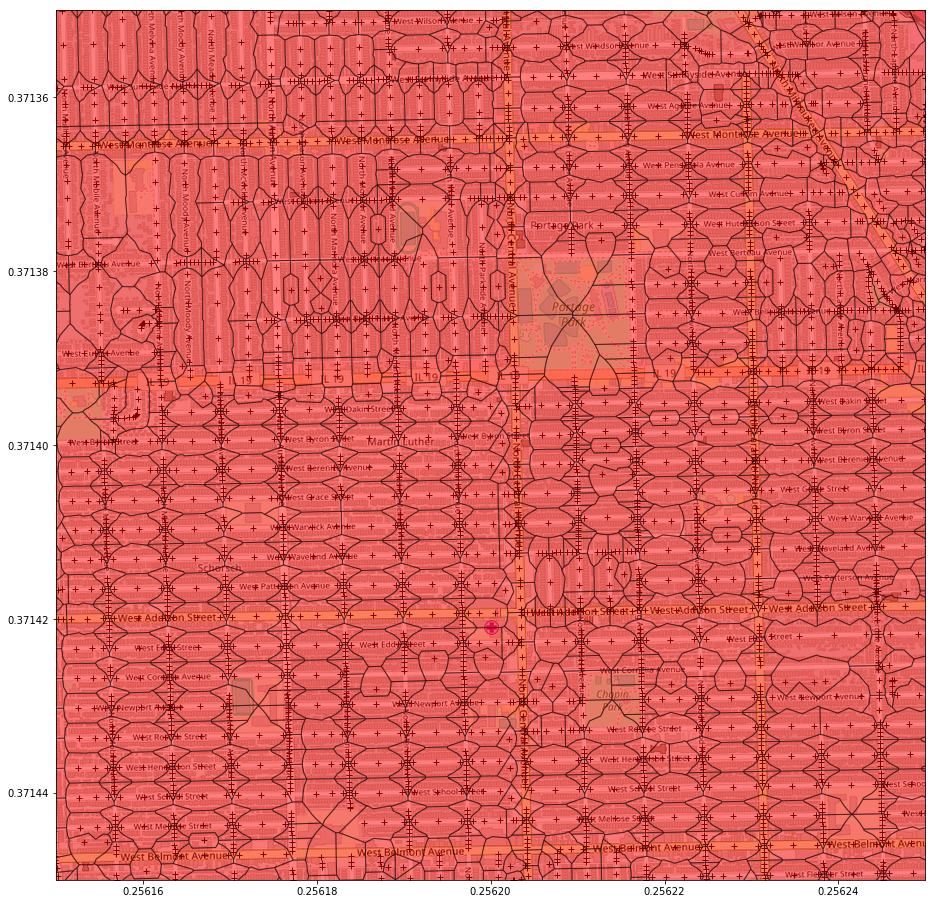

In [44]:
fig, ax = plt.subplots(figsize=(16,16))
ex = tilemapbase.Extent.from_centre(0.2562, 0.3714, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(ax)

for p in polygons_for_segments:
    coords = []
    try:
        for poly in p:
            coords.append( list(poly.exterior.coords) )
    except:
        coords.append( list(p.exterior.coords) )
    for poly in coords:
        poly = project_to_tilemapbase(poly)
        x, y = poly[0]
        d = (x-0.2562)**2 + (y-0.3714)**2
        if d < 0.0001**2:
            p = matplotlib.patches.Polygon(poly, ec="black", fc="red", alpha=0.5)
            ax.add_patch(p)
        
ax.scatter(*pt_wm.T, marker="+", color="black", linewidth=1)

In [48]:
frame = gpd.GeoDataFrame({"segment" : list(range(len(polygons_for_segments)))})
frame.geometry = polygons_for_segments
frame.crs = {"init":"epsg:3528"}
frame.head()

,segment,geometry
0,0,"POLYGON ((361303.2686379346 571758.4266984665,..."
1,1,"POLYGON ((356901.5544778294 580368.1437932507,..."
2,2,(POLYGON ((356906.4846176822 580374.7042858531...
3,3,"POLYGON ((357268.5305351893 580320.2668820918,..."
4,4,(POLYGON ((357546.7310073585 580369.1297258741...


In [49]:
frame.to_file("chicago_regions_segments")

### Criticism

This sort of works.

- It's possible for one event to "accidently" be snapped to an edge, thus including that edge and hence segment in the diagram.
  - As we only use the centre point of edges, this can lead to large areas in which actually no events fall.
  - Would also be a problem in the purely networked based model-- the event didn't "really" occur on this edge.
  - One possible approach is to think about whether we could snap the event to a _nearby_ instead of _nearest_ edge: we'd probably want to do this if we could move the event from an edge with few events on to an edge with many.
- The use of segments means that a side road (or alley) can split a "natural segment" into two (or more) parts.
  - So need to come up with some way of merging these.
  - One (first??) option would be to perhaps simplify the geometry-- if we remove segments where no event occured, can we then join segments based on topology.
  - 2nd option is to try to use name data.
  - Another idea: drop the "roads" from the graph which aren't named.  This might be too drastic though...

# More intelligent event snapping

## Next steps

We've assigned each event to the edge in the network.

- Want to union together all the edges which we think correspond to one "block"
  - The above says that 2426 (or slightly fewer, if I were to do more cleaning) edges have an ambiguous notion of "block"
  - **TODO**: Want to compare with the "name" that comes from the TIGER/Line data
  - Maybe check for outlyers-- if only 2% of the events give a block name, we can be fairly happy what the "real" name is.
  - Also need to think about what to do with edges which don't have any events on them?  _Ignore_ this for a 1st attempt.
- Then perform Voroni etc. to get a 2d space which corresponds to one "block"
- Then randomly assign points to that space.

[(583500, 583900), (358000, 358400)]

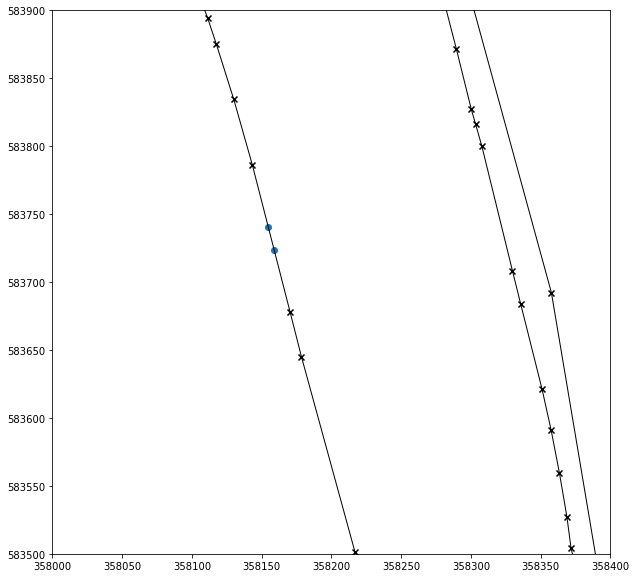

In [45]:
import matplotlib.collections

fig, ax = plt.subplots(figsize=(10,10))

lines = [[graph.vertices[v] for v in e] for e in graph.edges]
li = matplotlib.collections.LineCollection(lines, color="black", linewidth=1)
ax.add_collection(li)

ax.scatter(*np.asarray(list(graph.vertices.values())).T, marker="x", color="black")

ax.scatter([x, xx], [y, yy])
ax.set(xlim=[358000, 358400], ylim=[583500, 583900])